# Real and Fake Face detection
In this replository is a small application that uses a CNN to predict real or fake face.

Data has been collected from kaggle. For training ~1450 images and with an additional ~300 images for validation.

In [2]:
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense,MaxPool2D
import numpy as np
from keras.preprocessing import image
from keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
try:
    from tensorflow.python.util import module_wrapper as deprecation
except ImportError:
    from tensorflow.python.util import deprecation_wrapper as deprecation
deprecation._PER_MODULE_WARNING_LIMIT = 0

# Dataset

First let's load in the data I've collected from the program. I will use kera's ImageDataGenerator to not only label the data from the directories but also to slightly augment the data with shifts, rotations, zooms, and mirroring. Mirroring will help to ensure that the data are not biased to a particular handedness.

In [4]:
nbatch = 128
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10.,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('dataset/training',
                                                 target_size=(128,128),
                                                 batch_size =nbatch,
                                                 class_mode = 'binary')

test_set = test_datagen.flow_from_directory('dataset/test',
                                            target_size=(128,128),
                                            batch_size =nbatch,
                                            class_mode = 'binary')

Found 1437 images belonging to 2 classes.
Found 604 images belonging to 2 classes.


Text(0.5, 0, 'Class')

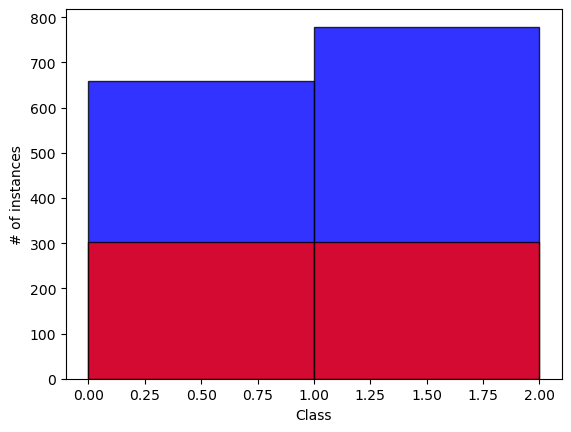

In [5]:
h1 = plt.hist(training_set.classes, bins=range(0,3), alpha=0.8, color='blue', edgecolor='black')
h2 = plt.hist(test_set.classes,  bins=range(0,3), alpha=0.8, color='red', edgecolor='black')
plt.ylabel('# of instances')
plt.xlabel('Class')

(128, 128, 128, 3) (128,)


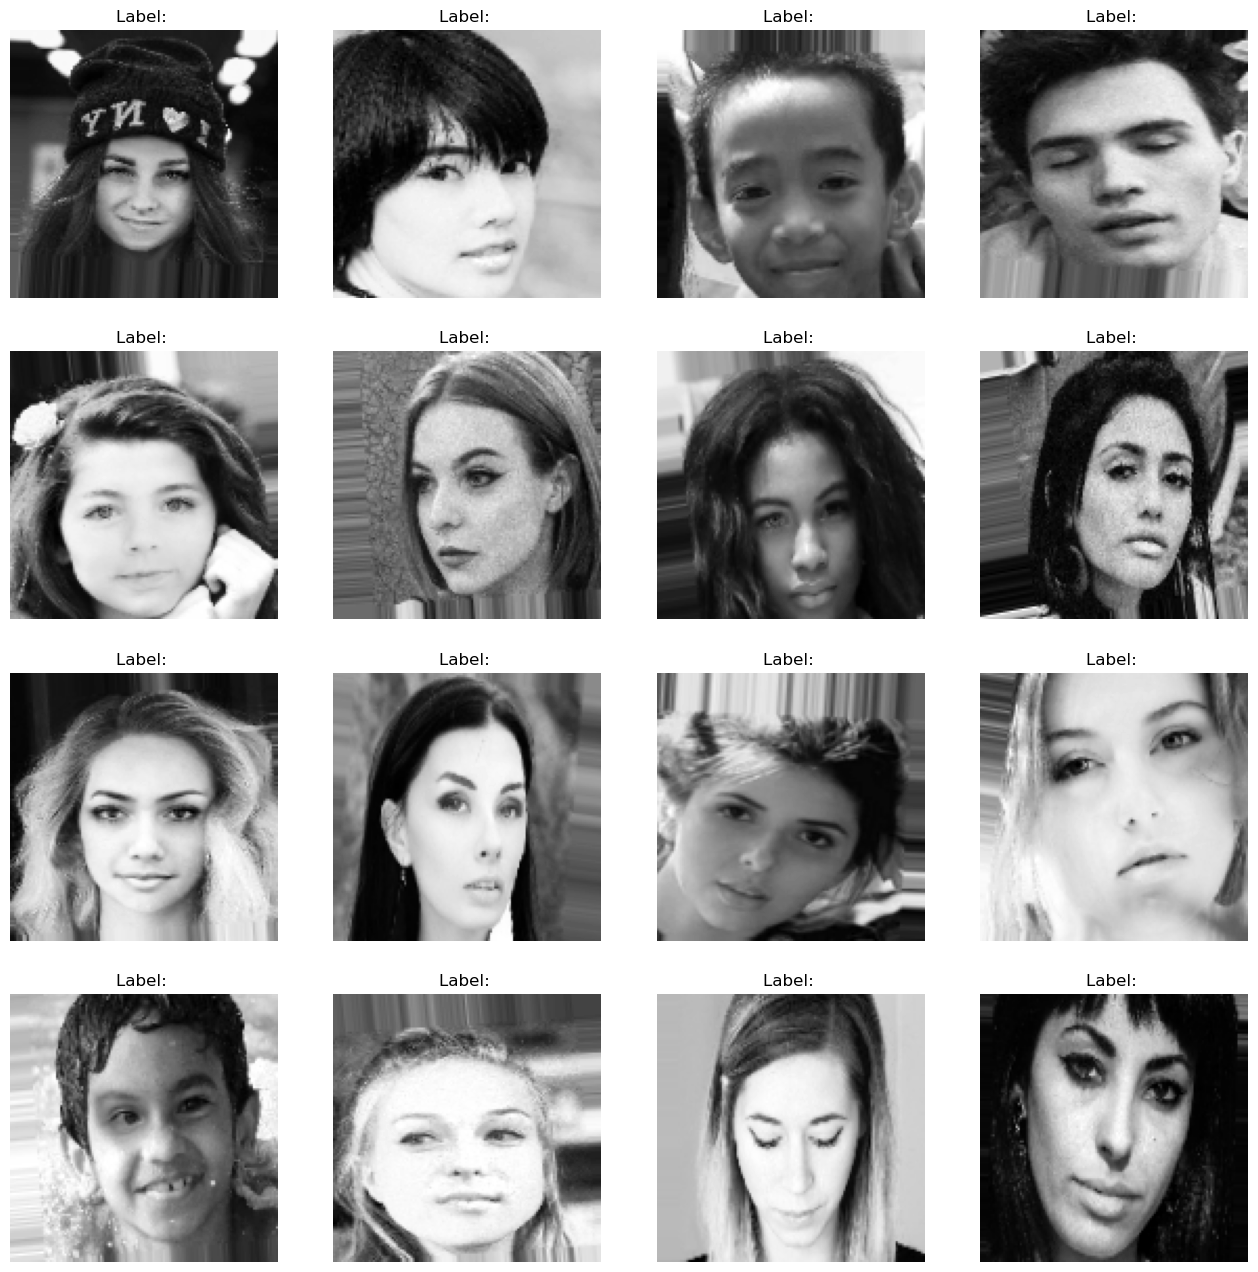

In [6]:
for X, y in training_set:
    print(X.shape, y.shape)
    plt.figure(figsize=(16,16))
    for i in range(16):
        plt.subplot(4,4,i+1)
        plt.axis('off')
        plt.title('Label: ')
        img = np.uint8(255*X[i,:,:,0])
        plt.imshow(img, cmap='gray')
    break

# Convolutional Neural Net
The data looks resonable so now I will define a CNN model to train and use within our application.

In [7]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(128,128,3)))

model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu'))

model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(128, kernel_size=(3, 3),
                 activation='relu'))

model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(activation="relu",
                units=256))

model.add(Dense(activation="sigmoid",
                units=1))

model.summary()

C:\Users\jahna\miniconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,516,289 (24.86 MB)

 Trainable params: 6,516,289 (24.86 MB)

 Non-trainable params: 0 (0.00 B)

##### Compile the model

In [8]:
model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

# Training
Finally we will train our model using some keras helper functions. We are not doing any hyper-parameter optimization so we will not define a separate testing and validation set. We can however evaluate our model further in real time within the application.

In [11]:
callbacks_list = [
    EarlyStopping(monitor='val_loss', patience=10),
    ModelCheckpoint(filepath='model_checkpoint.keras', monitor='val_loss', save_best_only=True, mode='max'),
]


In [13]:
history = model.fit(
    training_set,
    steps_per_epoch=80,
    epochs=10,
    validation_data=test_set,
    validation_steps=28,
    callbacks=callbacks_list
)

C:\Users\jahna\miniconda3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
12/80 ━━━━━━━━━━━━━━━━━━━━ 7:36 7s/step - accuracy: 0.5141 - loss: 1.1604

C:\Users\jahna\miniconda3\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


80/80 ━━━━━━━━━━━━━━━━━━━━ 130s 1s/step - accuracy: 0.4888 - loss: 0.9548 - val_accuracy: 0.5000 - val_loss: 0.6930
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - accuracy: 0.5395 - loss: 0.6930 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 75s 936ms/step - accuracy: 0.5422 - loss: 0.6925 - val_accuracy: 0.5000 - val_loss: 0.6939
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 75s 882ms/step - accuracy: 0.5417 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 5/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 57s 669ms/step - accuracy: 0.5414 - loss: 0.6920 - val_accuracy: 0.5000 - val_loss: 0.6933
Epoch 6/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 59s 684ms/step - accuracy: 0.5423 - loss: 0.6916 - val_accuracy: 0.5000 - val_loss: 0.6934
Epoch 7/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 57s 714ms/step - accuracy: 0.5419 - loss: 0.6916 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 8/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 54s 644ms/step - accuracy: 0.5429 - loss: 0.6908 - val_accuracy: 0.4983 - 

In [16]:
training_set.class_indices

{'fake': 0, 'real': 1}

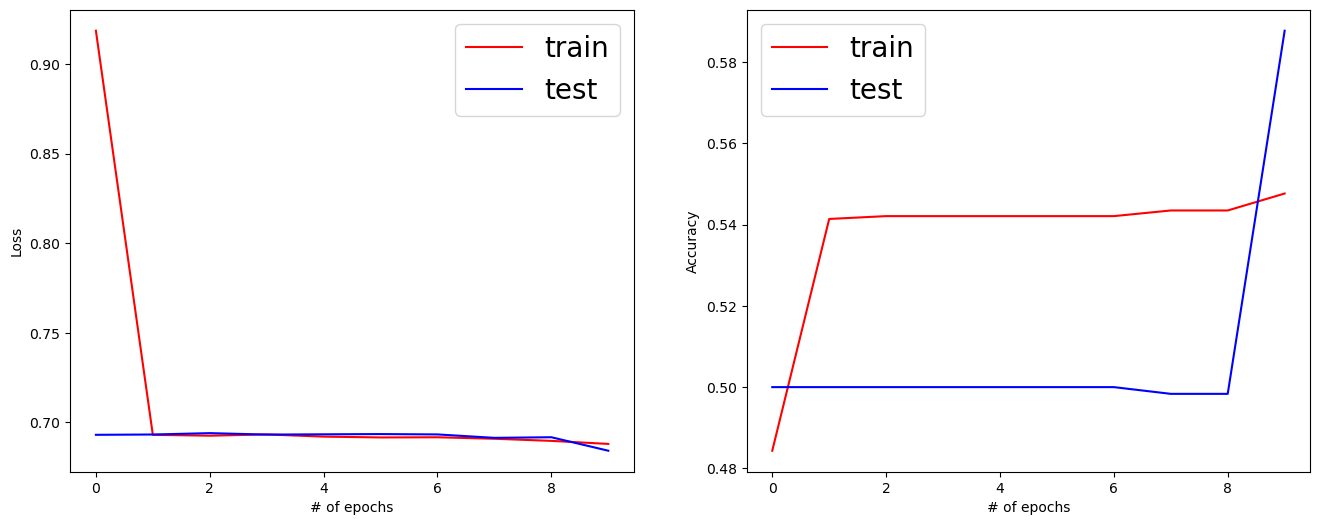

In [18]:
plt.figure(figsize=(16,6))

# Plot for loss
plt.subplot(1,2,1)
nepochs = len(history.history['loss'])
plt.plot(range(nepochs), history.history['loss'], 'r-', label='train')
plt.plot(range(nepochs), history.history['val_loss'], 'b-', label='test')
plt.legend(prop={'size': 20})
plt.ylabel('Loss')
plt.xlabel('# of epochs')

# Plot for accuracy
plt.subplot(1,2,2)
plt.plot(range(nepochs), history.history['accuracy'], 'r-', label='train')
plt.plot(range(nepochs), history.history['val_accuracy'], 'b-', label='test')
plt.legend(prop={'size': 20})
plt.ylabel('Accuracy')
plt.xlabel('# of epochs')

plt.show()

# Prediction
Now the model is trained so I used some real images and edited that image so that we can analysis model is working correcly or not.

In [19]:
def ImagePrediction(loc):
    test_image = image.load_img(loc, target_size = (128,128))
    plt.axis('off')
    plt.imshow(test_image)
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis =0)
    result = model.predict(test_image)
    if result[0][0] == 1:
        predictions = 'Real'
    else:
        predictions = 'Fake'
    print('Prediction: ',predictions)

Enter Location of Image to predict: dataset/face_pred/check2.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
Prediction:  Fake


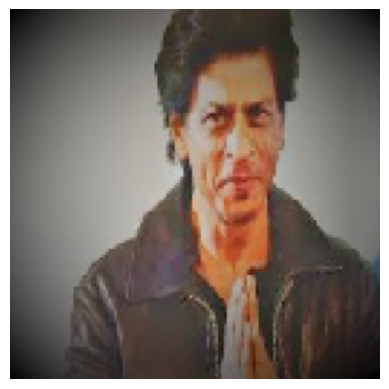

In [25]:
img = input("Enter Location of Image to predict: ")
test_image_1 = ImagePrediction(img)

Enter Location of Image to predict: dataset/face_pred/check.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Prediction:  Fake


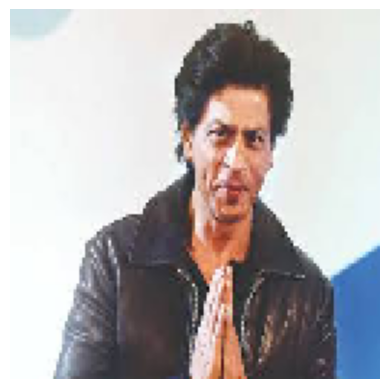

In [26]:
img = input("Enter Location of Image to predict: ")
test_image_2 = ImagePrediction(img)

Enter Location of Image to predict: dataset/face_pred/check3.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Prediction:  Fake


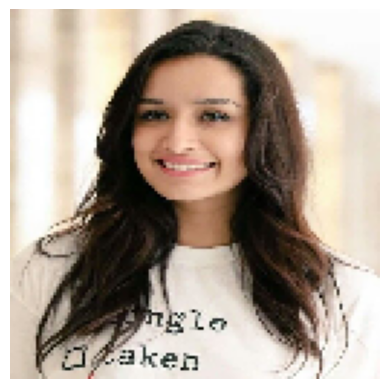

In [27]:
img = input("Enter Location of Image to predict: ")
test_image_3 = ImagePrediction(img)

Enter Location of Image to predict: dataset/face_pred/check4.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Prediction:  Fake


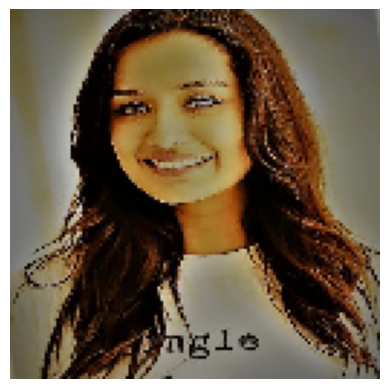

In [28]:
img = input("Enter Location of Image to predict: ")
test_image_3 = ImagePrediction(img)

## Result
3 out of 4 images is predicted correctly althrough model is not trained well by incereasing epoc near about 40 will probably make this model perfectly trained but that will require 5-6hr for training.